# Testing QPTE with quantumaudio

In [1]:
import quantumaudio as qa
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
import qiskit
from typing import Optional, Union, Callable, Any, Tuple

In [2]:
qiskit.__version__ #please use < 2.0

'1.4.0'

In [11]:
sqpam1 = qa.load_scheme('sqpam_qpte')
sqpam2 = qa.load_scheme('sqpam_qpte')

Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm
Single-Qubit Probability Amplitude Modulation Variant for QPTE algorithm


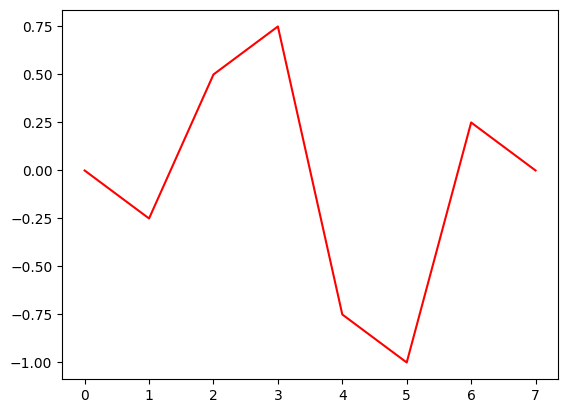

In [12]:
test_signal_1 = (np.array([0., -0.25, 0.5, 0.75, -0.75, -1, 0.25, 0.]))
test_signal_2 = np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])
plt.plot(test_signal_1, color='red')
plt.show()

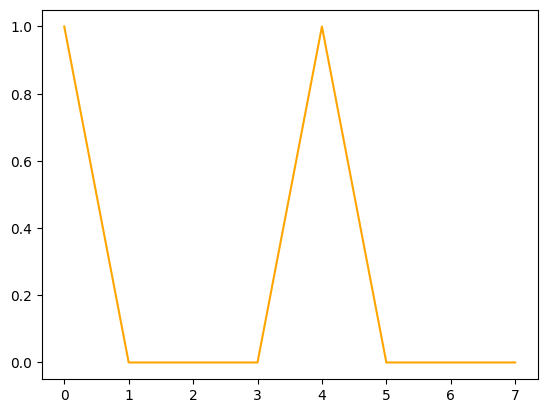

In [13]:
plt.plot(test_signal_2, color='orange')
plt.show()

In [14]:
def convert_to_angles_variant(array: np.ndarray) -> np.ndarray:
    mag = np.abs(array)
    phase = [True if x < 0 else False for x in array]
    return np.arccos(np.sqrt(mag)), phase

In [15]:
sqpam1.convert = convert_to_angles_variant
sqpam2.convert = convert_to_angles_variant

In [16]:
circuit1 = sqpam1.encode(test_signal_1, measure=False)
circuit2 = sqpam2.encode(test_signal_2, measure=False)

Number of qubits required: 4

3 qubits for time
1 qubits for amplitude
Number of qubits required: 4

3 qubits for time
1 qubits for amplitude


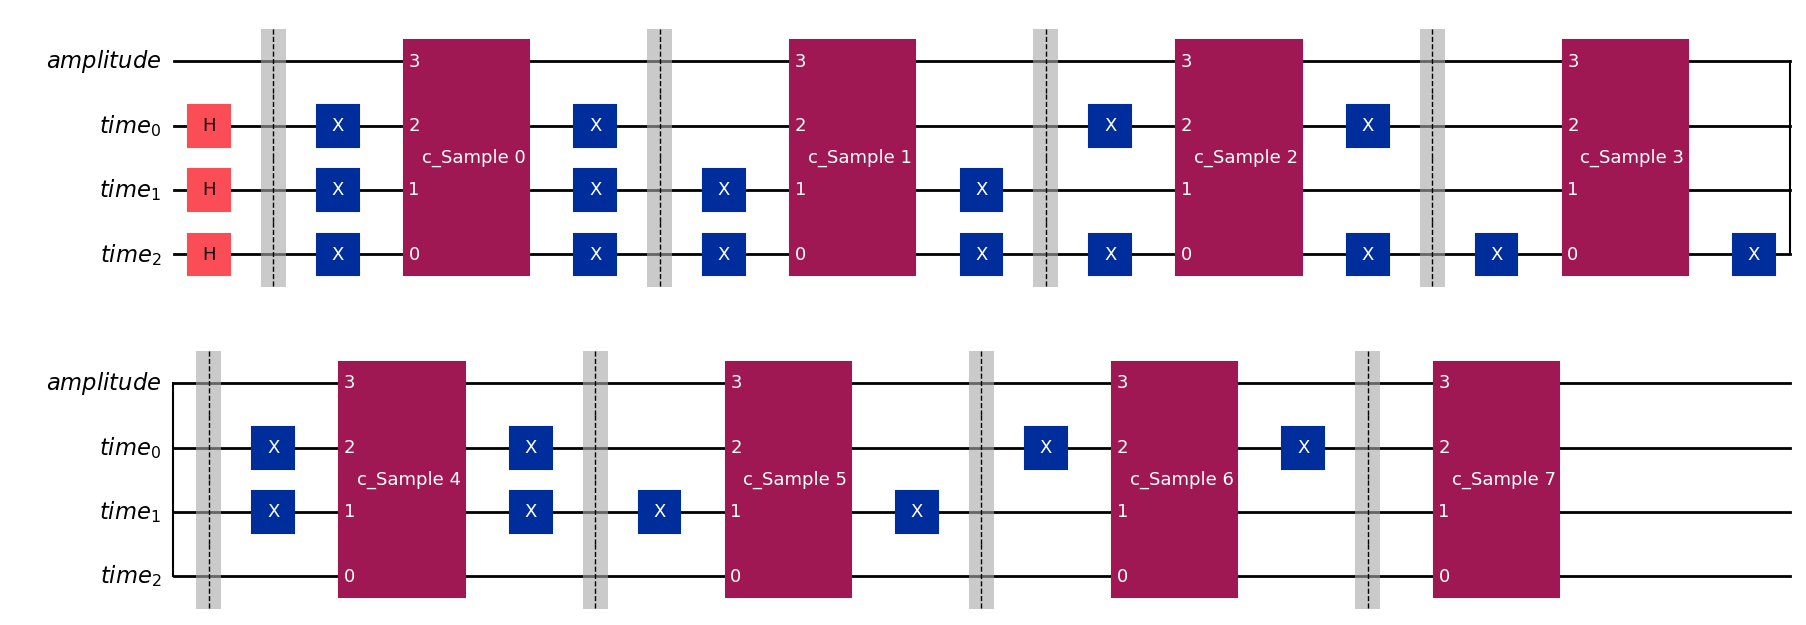

In [17]:
circuit1.draw('mpl')

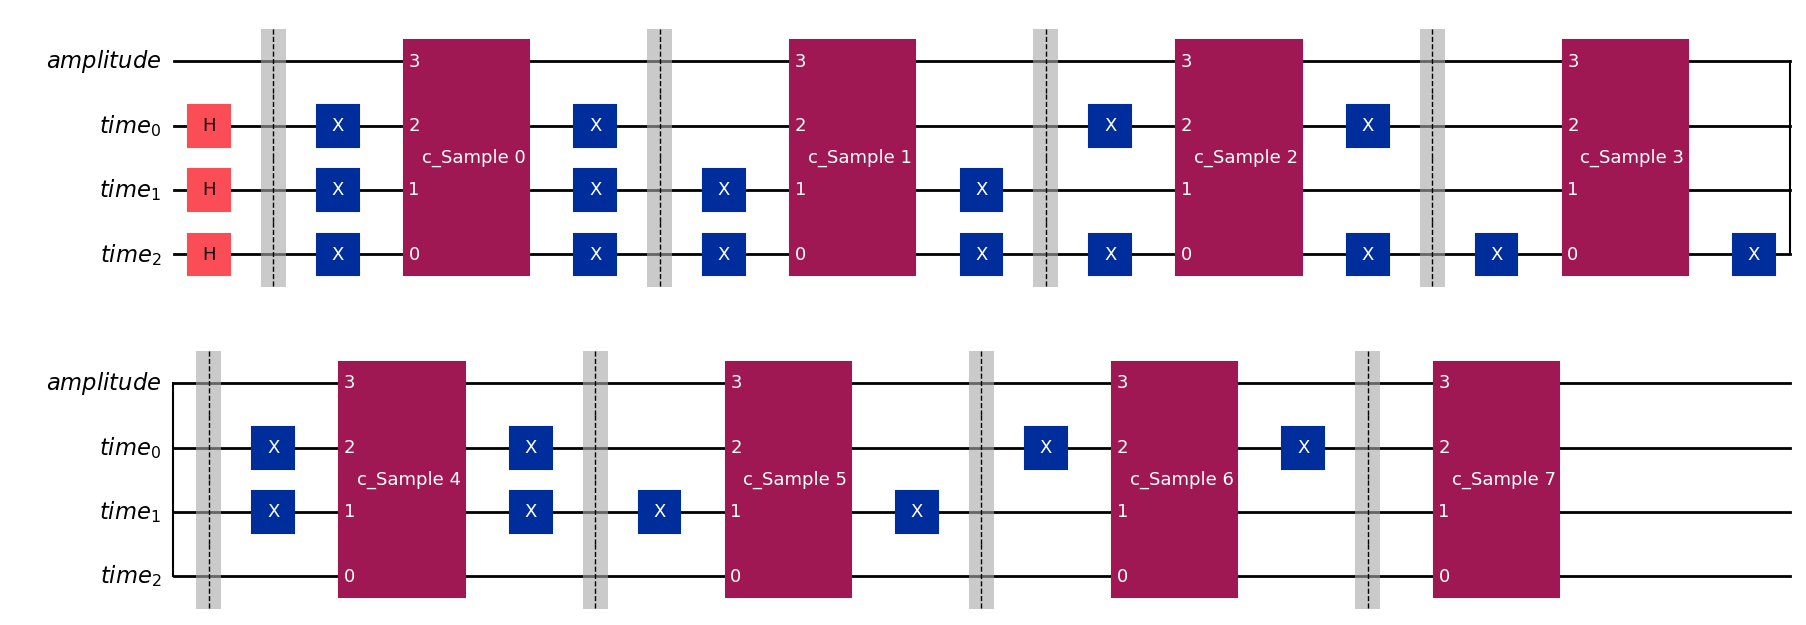

In [18]:
circuit2.draw('mpl')

In [11]:
for i in range(circuit2.metadata['qubit_shape'][0]):
    circuit2.data.pop(0)

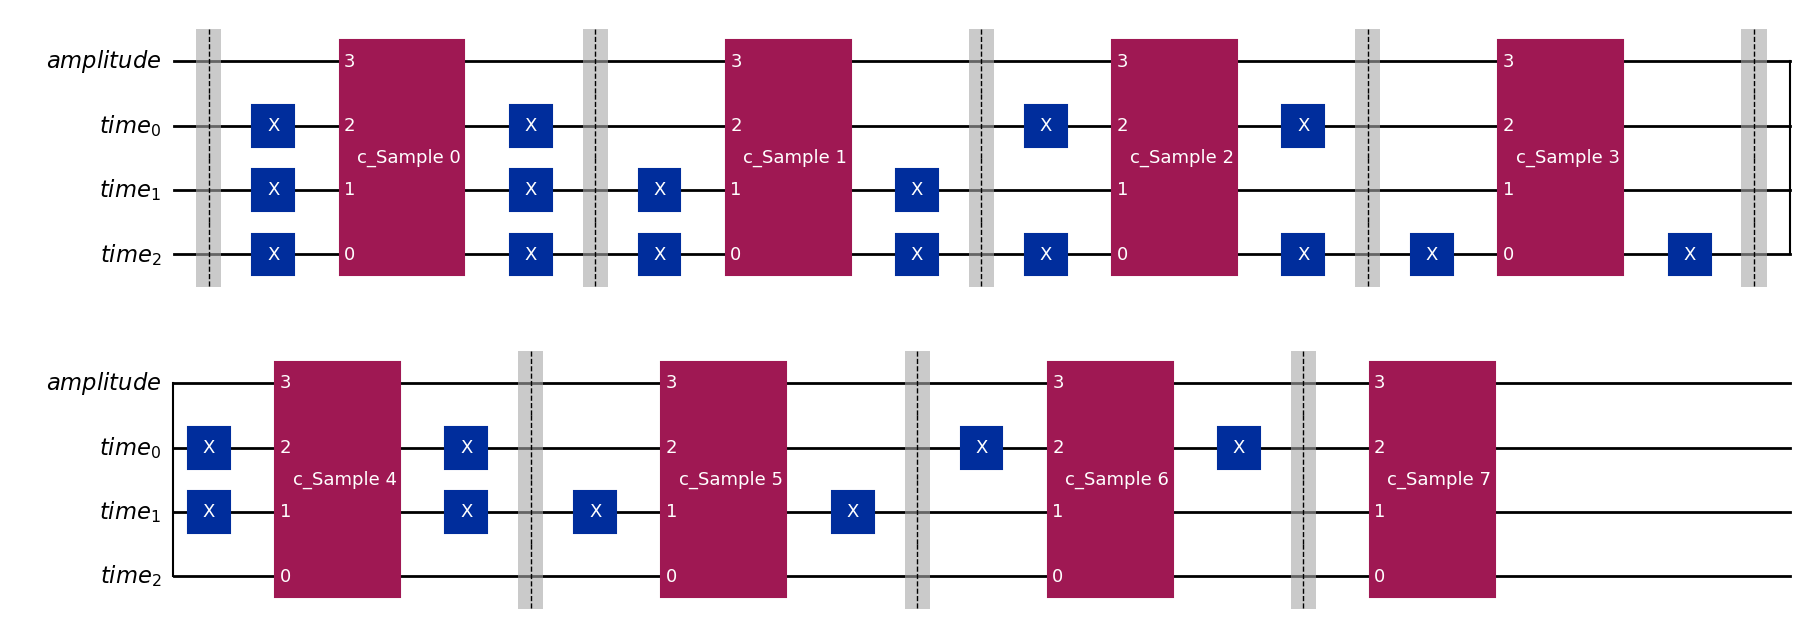

In [12]:
circuit2.draw('mpl')

In [49]:
circuit1.num_qubits

[1] + [x for x in range(2, circuit1.num_qubits+1)]

[1, 2, 3, 4]

In [13]:
ar = QuantumRegister(2, name='amplitude')

qpte = QuantumCircuit()
qpte.add_register(ar)
qpte.add_register(circuit1.qregs[1])
qpte.compose(circuit1, qubits=[0, 2, 3, 4],inplace=True)
qpte.compose(circuit2, qubits=[1, 2, 3, 4],inplace=True)
qpte.metadata = circuit1.metadata
qpte.metadata['qubit_shape'] = (circuit1.metadata['qubit_shape'][0], circuit1.metadata['qubit_shape'][1]+1)
qpte.measure_all()

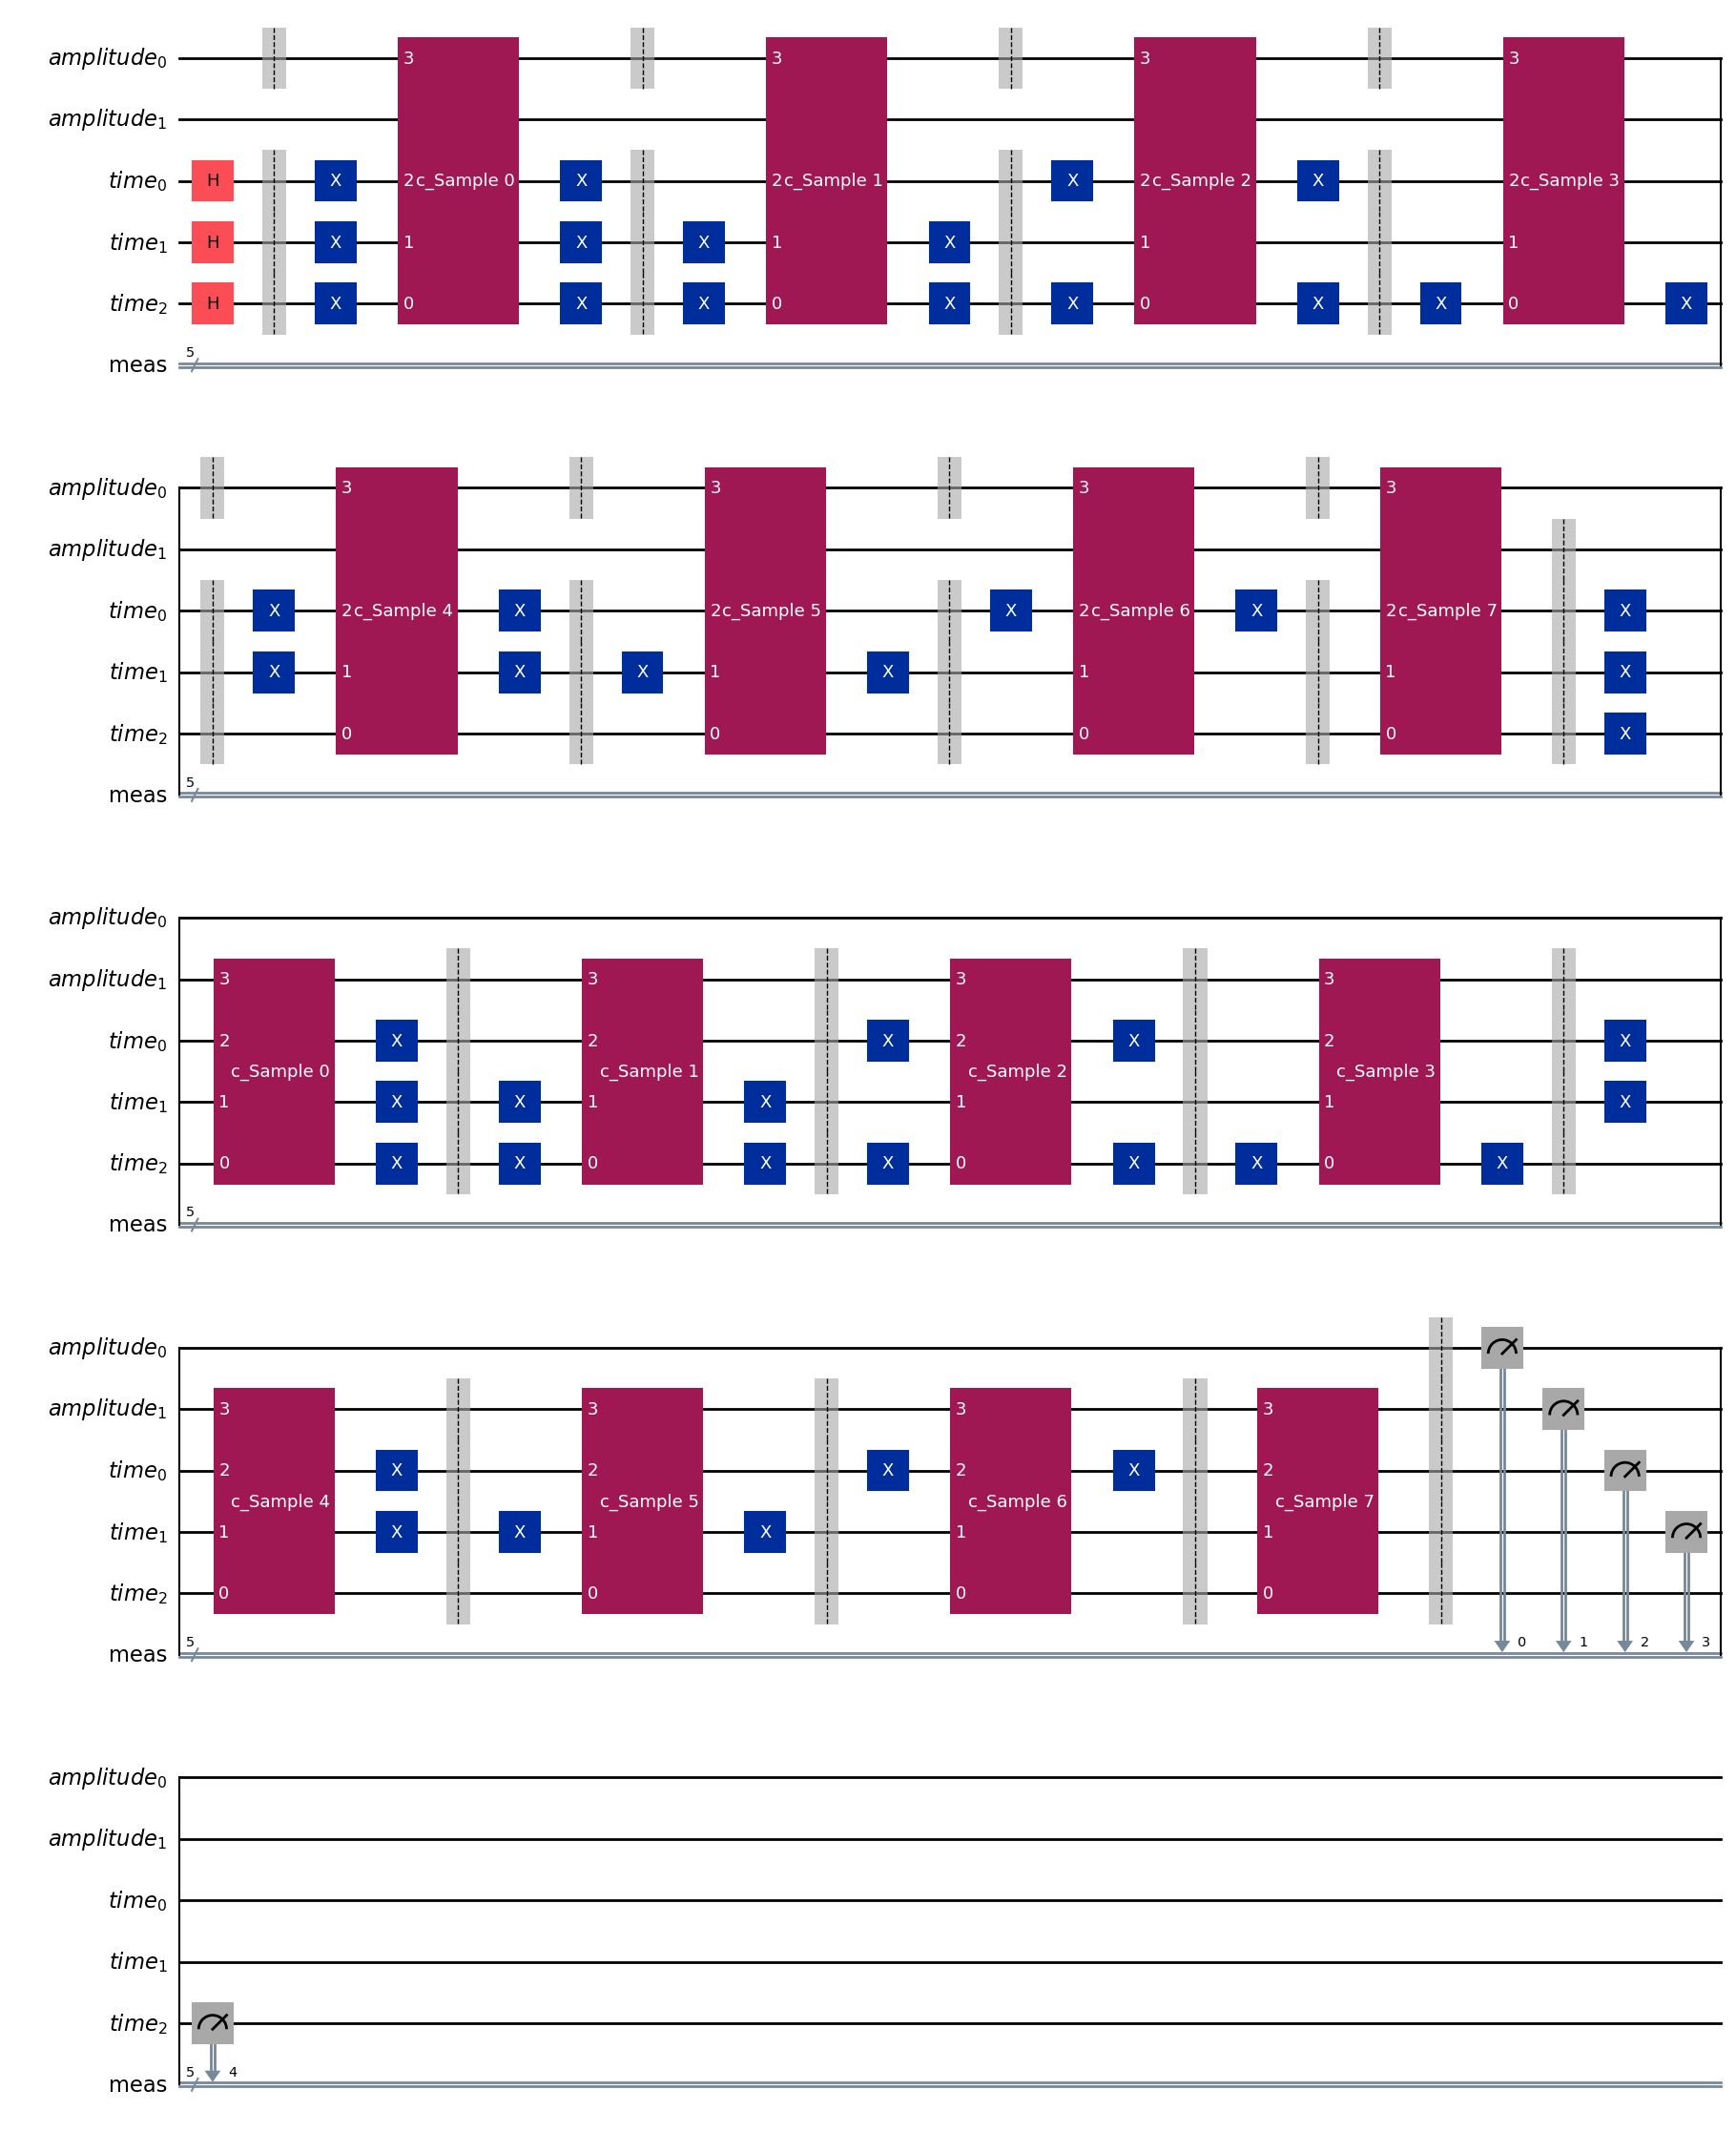

In [14]:
qpte.draw('mpl')

In [15]:
counts = qa.utils.execute(qpte, shots=1000000).get_counts()

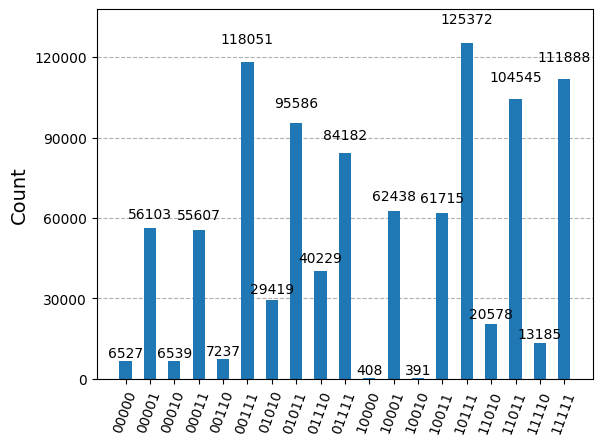

In [16]:
plot_histogram(counts)

In [17]:
qpte.metadata['qubit_shape']

(3, 2)

In [41]:
def decode_components(
        counts: Union[dict, qiskit.result.Counts],
        qubit_shape: [int, int],
    ) -> np.ndarray:
        """The first stage of decoding is extracting required components from
        counts.

        Args:
            counts: a dictionary with the outcome of measurements
                    performed on the quantum circuit.
            qubit_shape: Tuple to determine the number of cosine and sine components to get.

        Returns:
            Array of components for further decoding.
        """
        # initialising components
        num_index_qubits = qubit_shape[0]
        num_components = 2**num_index_qubits
        counts_00 = np.zeros(num_components)
        counts_01 = np.zeros(num_components)
        counts_10 = np.zeros(num_components)
        counts_11 = np.zeros(num_components)

        # getting components from counts
        for state in counts:
            index_bits, value_bits = qa.utils.split_string(state, qubit_shape)
            
            
            index = int(index_bits, 2)
            value = counts[state]
            if value_bits == "00":
                counts_00[index] = value
            elif value_bits == "01":
                counts_01[index] = value
            elif value_bits == "10":
                counts_10[index] = value
            elif value_bits == "11":
                counts_11[index] = value

        return counts_00, counts_01, counts_10, counts_11

In [29]:
sqpam1.decode(qpte, inverted=1)

array([-1., -1., -1., -1., -1., -1., -1., -1.])

In [30]:
qpte.metadata



{'num_samples': 8, 'qubit_shape': (3, 2), 'scheme': 'SQPAM', 'shots': 8000}

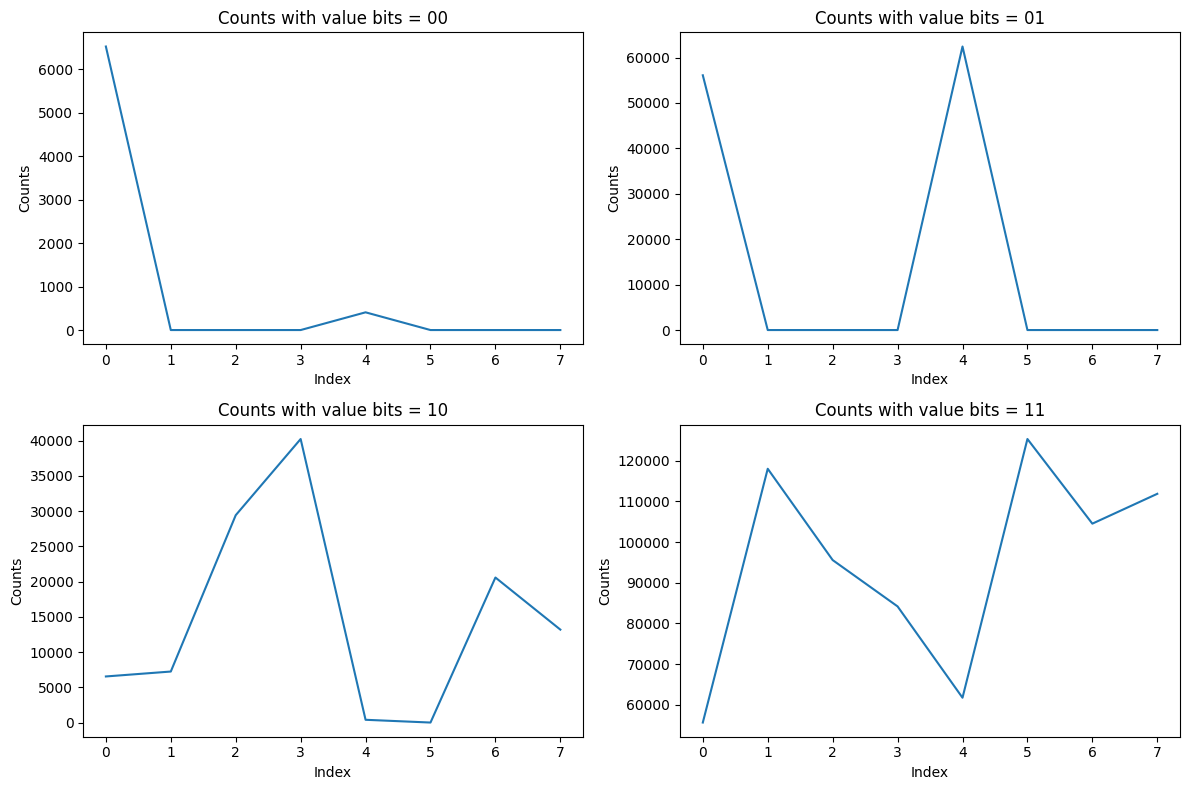

In [44]:
counts_00, counts_01, counts_10, counts_11 = decode_components(counts, (3,2))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
num_components=8
# Plot for bits == '00'
axs[0, 0].plot(range(num_components), counts_00)
axs[0, 0].set_title("Counts with value bits = 00")
axs[0, 0].set_xlabel("Index")
axs[0, 0].set_ylabel("Counts")

# Plot for bits == '01'
axs[0, 1].plot(range(num_components), counts_01)
axs[0, 1].set_title("Counts with value bits = 01")
axs[0, 1].set_xlabel("Index")
axs[0, 1].set_ylabel("Counts")

# Plot for bits == '10'
axs[1, 0].plot(range(num_components), counts_10)
axs[1, 0].set_title("Counts with value bits = 10")
axs[1, 0].set_xlabel("Index")
axs[1, 0].set_ylabel("Counts")

# Plot for bits == '11'
axs[1, 1].plot(range(num_components), counts_11)
axs[1, 1].set_title("Counts with value bits = 11")
axs[1, 1].set_xlabel("Index")
axs[1, 1].set_ylabel("Counts")

# Set the same y-range for all subplots
# max_count_value = max(counts.values())
# for row in axs:
#     for ax in row:
#         ax.set_ylim([0, max_count_value * 1.1])

plt.tight_layout()
plt.show()

In [22]:
def convert_from_angles(
    amps_00: np.ndarray, amps_01: np.ndarray, amps_10: np.ndarray, amps_11: np.ndarray, which: int = 0
) -> np.ndarray:

    total_amps = amps_00 + amps_01 + amps_10 + amps_11
    all_amps = [amps_00, amps_01, amps_10, amps_11]
    amps = all_amps[which]
    ratio = np.divide(
        amps, total_amps, out=np.zeros_like(amps), where=total_amps != 0
    )
    data = np.sqrt(ratio)
    return data

In [32]:
def reconstruct_data(
    self,
    counts: Union[dict, qiskit.result.Counts],
    qubit_shape: [int, int],
    which: int = 0,
) -> np.ndarray:
    """Given counts, Extract components and restore the conversion did at
    encoding stage.

    Args:
        counts: a dictionary with the outcome of measurements
                performed on the quantum circuit.
        qubit_shape: Tuple to determine the number of cosine and sine components to get.
        inverted : retrieves cosine components of the signal.

    Return:
        Array of restored values
    """
    cc_amps, cs_amps, sc_amps, ss_amps = self.decode_components(counts, qubit_shape)
    data = self.restore(cosine_amps, sine_amps, inverted)
    return data

In [34]:
def decode_counts(
        self,
        counts: Union[dict, qiskit.result.Counts],
        metadata: dict,
        which: int = 0,
        keep_padding: bool = False,
    ) -> np.ndarray:
        """Given a Qiskit counts object or Dictionary, Extract components and restore the
        conversion did at encoding stage.

        Args:
                counts: a qiskit Counts object or Dictionary obtained from a job result.
                metadata: metadata required for decoding.
                inverted: retrieves cosine components of the signal.
                keep_padding: Undo the padding set at Encoding stage if set False.

        Return:
                Array of restored values with original dimensions
        """
        # decoding x-axis
        index_position, _ = self.positions
        qubit_shape = metadata["qubit_shape"]

        original_num_samples = metadata["num_samples"]

        # decoding y-axis
        data = self.reconstruct_data(
            counts=counts, qubit_shape=qubit_shape, which=which
        )

        # undo padding
        if not keep_padding:
            data = data[:original_num_samples]

        return data

In [ ]:
def decode_result(
        self,
        result: qiskit.result.Result,
        metadata: Optional[dict] = None,
        inverted: bool = False,
        keep_padding: bool = False,
    ) -> np.ndarray:
        """Given a result object. Extract components and restore the conversion
        did in encoding stage.

        Args:
                result: a qiskit Result object that contains counts along
                        with metadata that was held by the original circuit.
                metadata: optionally pass metadata as argument.
                inverted: retrieves cosine components of the signal.
                keep_padding: Undo the padding set at Encoding stage if set False.

        Return:
                Array of restored values with original dimensions
        """
        counts = utils.get_counts(result)
        metadata = utils.get_metadata(result) if not metadata else metadata

        data = self.decode_counts(
            counts=counts,
            metadata=metadata,
            inverted=inverted,
            keep_padding=keep_padding,
        )
        return data

In [24]:
outs = [None]*4
for i, out in enumerate(outs):
    outs[i] = convert_from_angles(counts_00, counts_01, counts_10, counts_11, i)

NameError: name 'counts_00' is not defined

NameError: name 'num_components' is not defined

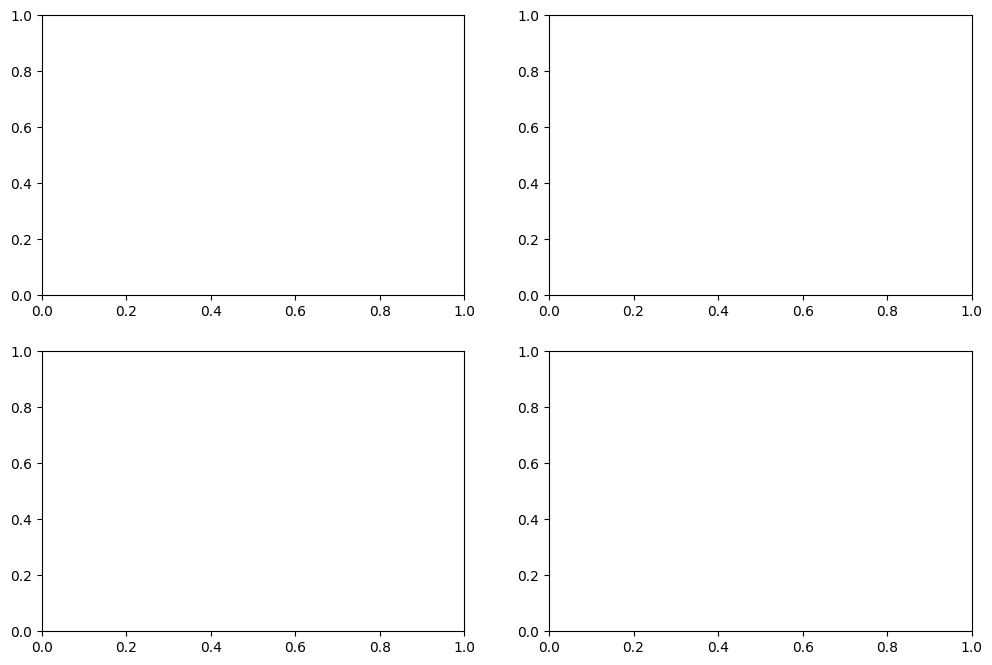

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(range(num_components), outs[0])
axs[0, 0].set_title("Counts with value bits = 00")
axs[0, 0].set_xlabel("Index")
axs[0, 0].set_ylabel("Counts")

axs[0, 1].plot(range(num_components), outs[1])
axs[0, 1].set_title("Counts with value bits = 01")
axs[0, 1].set_xlabel("Index")
axs[0, 1].set_ylabel("Counts")

axs[1, 0].plot(range(num_components), outs[2])
axs[1, 0].set_title("Counts with value bits = 10")
axs[1, 0].set_xlabel("Index")
axs[1, 0].set_ylabel("Counts")

axs[1, 1].plot(range(num_components), outs[3])
axs[1, 1].set_title("Counts with value bits = 11")
axs[1, 1].set_xlabel("Index")
axs[1, 1].set_ylabel("Counts")


# max_count_value = max(counts.values())
# for row in axs:
#     for ax in row:
#         ax.set_ylim([0, max_count_value * 1.1])

plt.tight_layout()
plt.show()

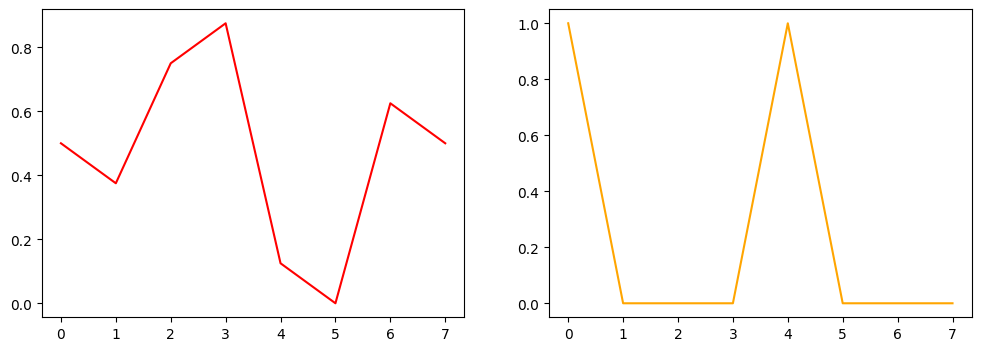

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(test_signal_1, color='red')
axs[1].plot(test_signal_2, color='orange')

ValueError: x, y, and format string must not be None

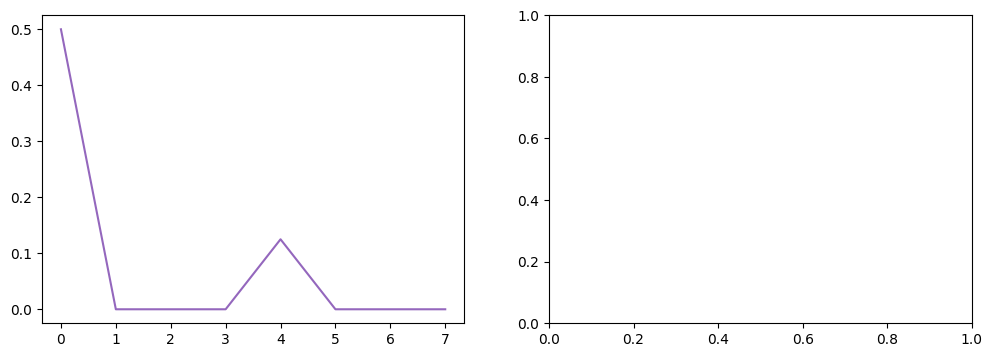

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(test_signal_1*test_signal_2, color='C4')
axs[1].plot(outs[0], color='darkblue')